In [7]:
#!pip install -q xgboost scikit-learn pandas numpy matplotlib seaborn scipy

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)


Processing 1M timeframe

Train: 75660 rows
Test: 13620 rows
Train: 60528, Validation: 15132, Test: 13620
Model training completed

Validation Metrics
MAE: 9.7784
RMSE: 12.7780
R2: 0.6592
sMAPE: 34.90%
Residuals mean: -0.95, std: 12.74
Within +/-10%: 19.7%, Within +/-20%: 38.5%

Test Metrics
MAE: 10.6206
RMSE: 14.0874
R2: 0.7258
sMAPE: 31.54%
Residuals mean: -0.79, std: 14.07
Within +/-10%: 22.3%, Within +/-20%: 42.5%


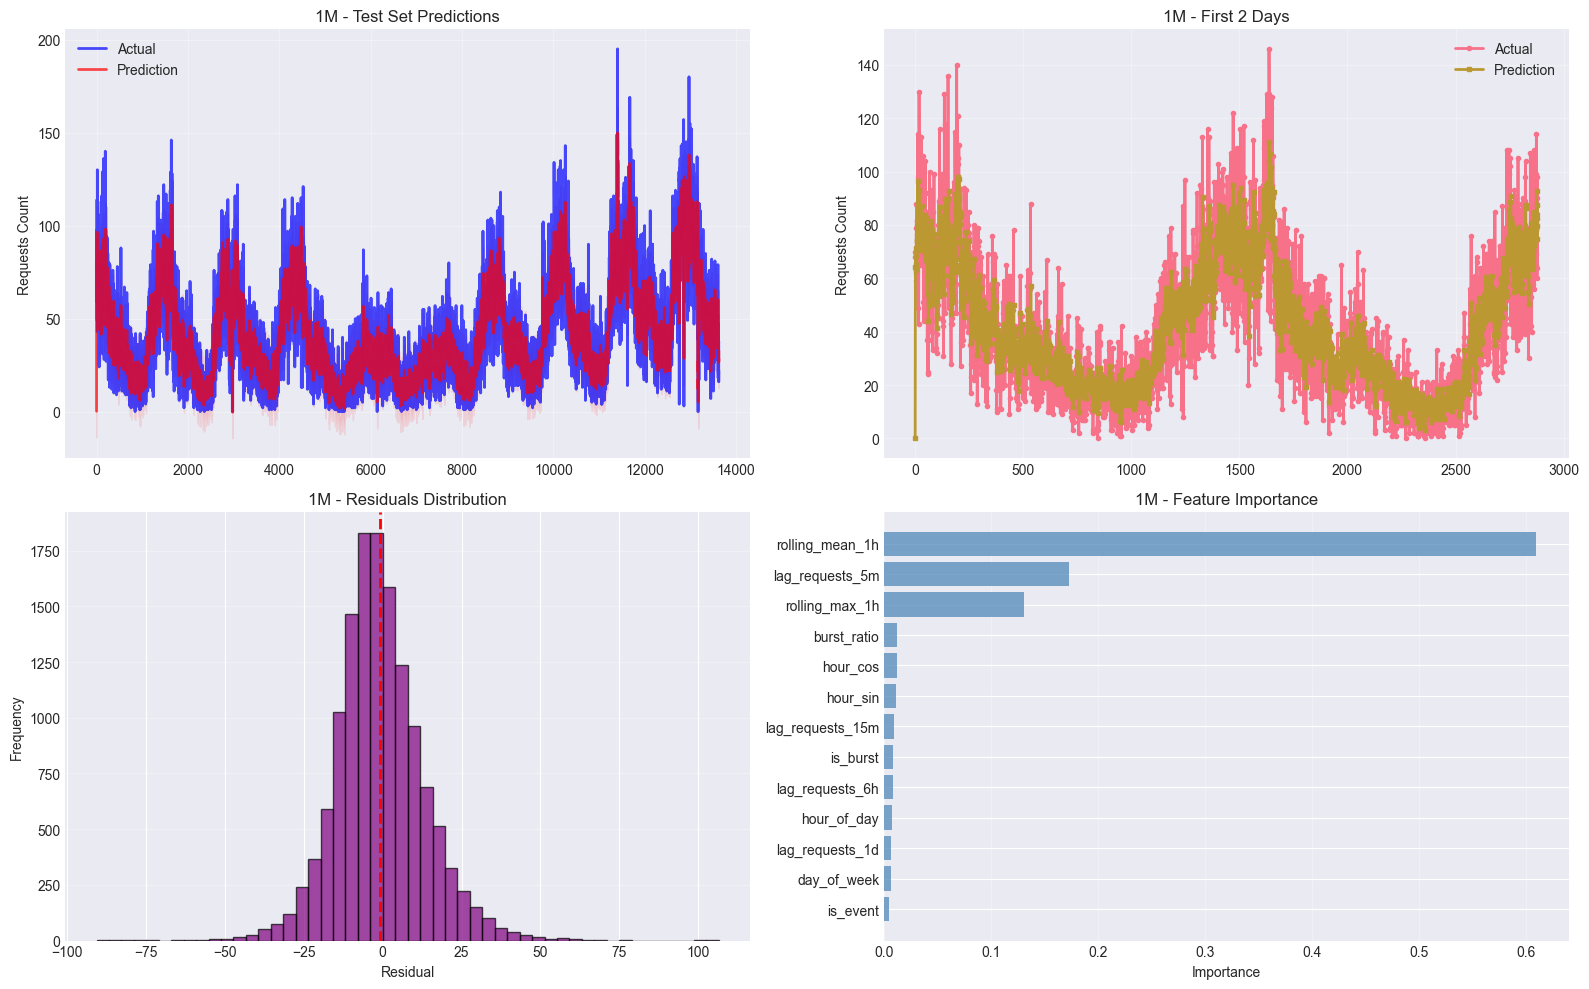

Figure saved: xgboost_1m_results.png
Predictions exported: xgboost_1m_predictions.csv
Feature importance exported: xgboost_1m_importance.csv
Top 5 Features:
        feature  importance
rolling_mean_1h    0.609282
lag_requests_5m    0.172440
 rolling_max_1h    0.130558
    burst_ratio    0.012005
       hour_cos    0.011875

Processing 5M timeframe

Train: 15132 rows
Test: 2724 rows
Train: 12105, Validation: 3027, Test: 2724
Model training completed

Validation Metrics
MAE: 32.1972
RMSE: 44.0064
R2: 0.7915
sMAPE: 22.25%
Residuals mean: -3.52, std: 43.87
Within +/-10%: 31.3%, Within +/-20%: 56.9%

Test Metrics
MAE: 35.4683
RMSE: 47.5276
R2: 0.8477
sMAPE: 20.61%
Residuals mean: -3.18, std: 47.42
Within +/-10%: 34.4%, Within +/-20%: 60.5%


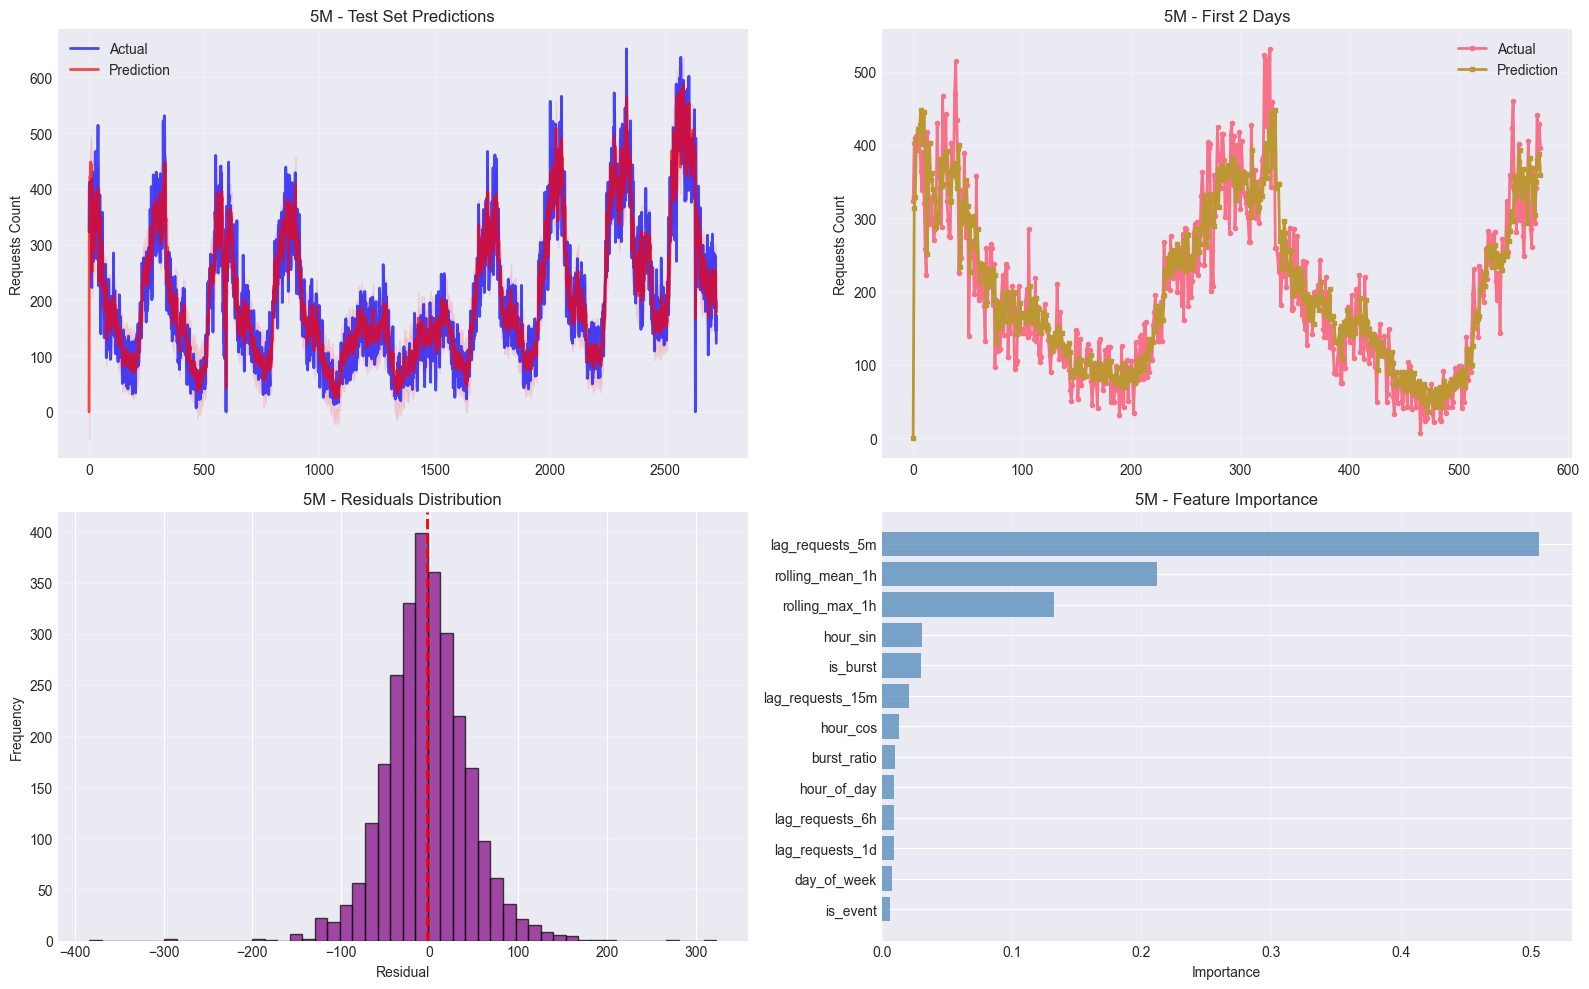

Figure saved: xgboost_5m_results.png
Predictions exported: xgboost_5m_predictions.csv
Feature importance exported: xgboost_5m_importance.csv
Top 5 Features:
        feature  importance
lag_requests_5m    0.506061
rolling_mean_1h    0.212329
 rolling_max_1h    0.132493
       hour_sin    0.031133
       is_burst    0.030551

Processing 15M timeframe

Train: 5044 rows
Test: 908 rows
Train: 4035, Validation: 1009, Test: 908
Model training completed

Validation Metrics
MAE: 73.5115
RMSE: 98.5929
R2: 0.8699
sMAPE: 16.95%
Residuals mean: -10.07, std: 98.08
Within +/-10%: 39.5%, Within +/-20%: 69.3%

Test Metrics
MAE: 86.4203
RMSE: 123.8028
R2: 0.8767
sMAPE: 16.00%
Residuals mean: -6.47, std: 123.63
Within +/-10%: 42.0%, Within +/-20%: 70.9%


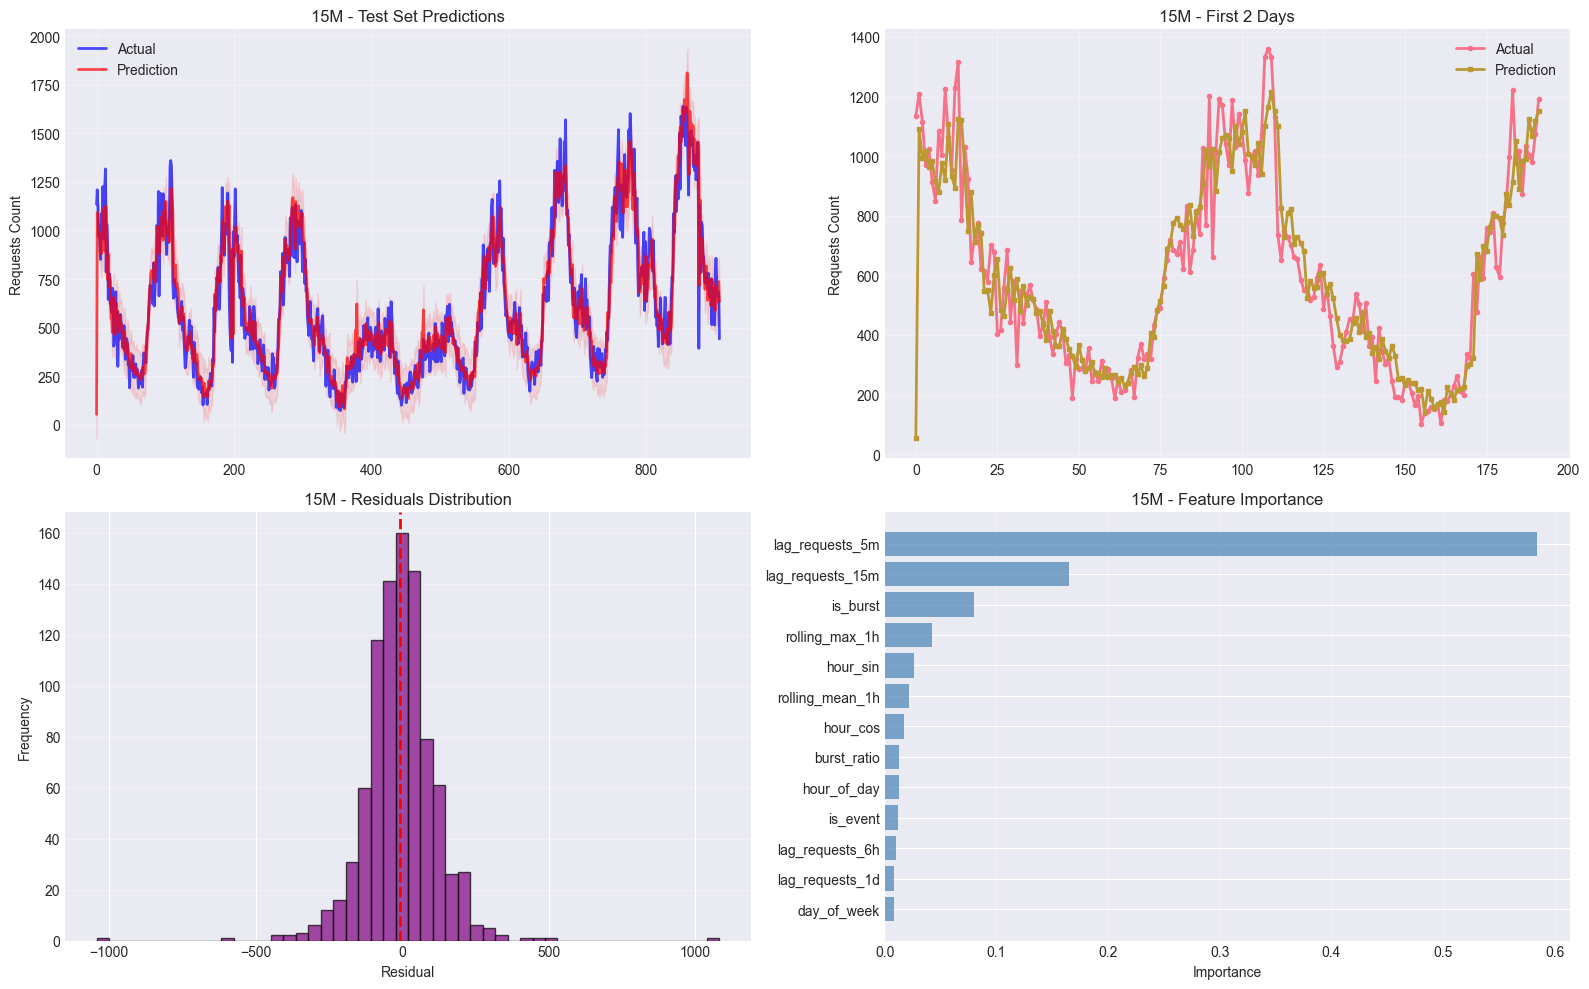

Figure saved: xgboost_15m_results.png
Predictions exported: xgboost_15m_predictions.csv
Feature importance exported: xgboost_15m_importance.csv
Top 5 Features:
         feature  importance
 lag_requests_5m    0.584408
lag_requests_15m    0.165086
        is_burst    0.080271
  rolling_max_1h    0.042400
        hour_sin    0.026105

SUMMARY: Performance across all timeframes

1M:
  Test MAE: 10.6206
  Test R2: 0.7258
  Test sMAPE: 31.54%

5M:
  Test MAE: 35.4683
  Test R2: 0.8477
  Test sMAPE: 20.61%

15M:
  Test MAE: 86.4203
  Test R2: 0.8767
  Test sMAPE: 16.00%


In [9]:
# 3 time intervals: 1m, 5m, 15m
timeframes = ['1m', '5m', '15m']
results_all = {}

for tf in timeframes:
    print(f"\n{'='*60}")
    print(f"Processing {tf.upper()} timeframe")
    print(f"{'='*60}\n")

    # Load data for current timeframe
    TRAIN_PATH = f"../datasets/train_{tf}_autoscaling.csv"
    TEST_PATH = f"../datasets/test_{tf}_autoscaling.csv"

    train_df = pd.read_csv(TRAIN_PATH, parse_dates=["timestamp"])
    test_df = pd.read_csv(TEST_PATH, parse_dates=["timestamp"])

    print(f"Train: {train_df.shape[0]} rows")
    print(f"Test: {test_df.shape[0]} rows")

    # Select independent features (no leakage) - updated with new lag/rolling
    independent_features = [
        'is_burst', 'burst_ratio', 'is_event',
        'hour_of_day', 'day_of_week', 'hour_sin', 'hour_cos',
        'lag_requests_5m',
        'lag_requests_15m',
        'rolling_max_1h',
        'rolling_mean_1h',
        'lag_requests_6h',
        'lag_requests_1d'
    ]

    # Prepare feature matrices
    X_train_full = train_df[independent_features].fillna(0).values
    y_train_full = train_df['requests_count'].values
    X_test = test_df[independent_features].fillna(0).values
    y_test = test_df['requests_count'].values

    # Time-based split (chronological order, no shuffle)
    split_idx = int(len(X_train_full) * 0.8)
    X_train = X_train_full[:split_idx]
    y_train = y_train_full[:split_idx]
    X_valid = X_train_full[split_idx:]
    y_valid = y_train_full[split_idx:]

    print(f"Train: {len(X_train)}, Validation: {len(X_valid)}, Test: {len(X_test)}")

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)
    X_test_scaled = scaler.transform(X_test)

    # XGBoost hyperparameters
    hyperparams = {
        'n_estimators': 200,
        'max_depth': 6,
        'learning_rate': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42,
        'verbosity': 0
    }

    # Train model
    xgb_model = xgb.XGBRegressor(**hyperparams)
    xgb_model.fit(
        X_train_scaled, y_train,
        eval_set=[(X_valid_scaled, y_valid)],
        verbose=False
    )

    print("Model training completed")

    # Generate predictions
    y_valid_pred = xgb_model.predict(X_valid_scaled)
    y_test_pred = xgb_model.predict(X_test_scaled)

    def compute_metrics(y_true, y_pred, name):
        # Calculate error metrics
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)

        # sMAPE calculation
        with np.errstate(divide='ignore', invalid='ignore'):
            smape_arr = 2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))
            smape_arr = np.nan_to_num(smape_arr, nan=0, posinf=0, neginf=0)
            smape = np.mean(smape_arr) * 100

        residuals = y_true - y_pred

        print(f"\n{name}")
        print(f"MAE: {mae:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"R2: {r2:.4f}")
        print(f"sMAPE: {smape:.2f}%")
        print(f"Residuals mean: {residuals.mean():.2f}, std: {residuals.std():.2f}")

        within_10 = ((np.abs(residuals) / (y_true + 1e-6)) <= 0.1).sum() / len(y_true) * 100
        within_20 = ((np.abs(residuals) / (y_true + 1e-6)) <= 0.2).sum() / len(y_true) * 100
        print(f"Within +/-10%: {within_10:.1f}%, Within +/-20%: {within_20:.1f}%")

        return {'mae': mae, 'rmse': rmse, 'r2': r2, 'smape': smape, 'residuals': residuals}

    valid_m = compute_metrics(y_valid, y_valid_pred, 'Validation Metrics')
    test_m = compute_metrics(y_test, y_test_pred, 'Test Metrics')

    # Store results for summary
    results_all[tf] = {
        'valid': valid_m,
        'test': test_m,
        'y_test': y_test,
        'y_test_pred': y_test_pred,
        'model': xgb_model,
        'features': independent_features
    }

    # Visualize predictions
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    time_idx = np.arange(len(y_test))

    # Test predictions over time
    ax = axes[0, 0]
    ax.plot(time_idx, y_test, label='Actual', linewidth=2, color='blue', alpha=0.7)
    ax.plot(time_idx, y_test_pred, label='Prediction', linewidth=2, color='red', alpha=0.7)
    ax.fill_between(time_idx, y_test_pred - test_m['residuals'].std(),
                      y_test_pred + test_m['residuals'].std(),
                      color='red', alpha=0.1)
    ax.set_title(f'{tf.upper()} - Test Set Predictions')
    ax.set_ylabel('Requests Count')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # First 2 days detailed
    ax = axes[0, 1]
    n = 288 if tf == '5m' else (1440 if tf == '1m' else 96)
    ax.plot(time_idx[:n*2], y_test[:n*2], 'o-', label='Actual', linewidth=2, markersize=3)
    ax.plot(time_idx[:n*2], y_test_pred[:n*2], 's-', label='Prediction', linewidth=2, markersize=3)
    ax.set_title(f'{tf.upper()} - First 2 Days')
    ax.set_ylabel('Requests Count')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Residuals distribution
    ax = axes[1, 0]
    ax.hist(test_m['residuals'], bins=50, color='purple', alpha=0.7, edgecolor='black')
    ax.axvline(test_m['residuals'].mean(), color='red', linestyle='--', linewidth=2)
    ax.set_title(f'{tf.upper()} - Residuals Distribution')
    ax.set_xlabel('Residual')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3, axis='y')

    # Feature importance
    ax = axes[1, 1]
    imp_df = pd.DataFrame({
        'feature': independent_features,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=True)
    ax.barh(imp_df['feature'], imp_df['importance'], color='steelblue', alpha=0.7)
    ax.set_title(f'{tf.upper()} - Feature Importance')
    ax.set_xlabel('Importance')
    ax.grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    plt.savefig(f'xgboost_{tf}_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Figure saved: xgboost_{tf}_results.png")

    # Export results for current timeframe
    results = pd.DataFrame({
        'actual': y_test,
        'predicted': y_test_pred,
        'error': y_test - y_test_pred,
        'abs_error': np.abs(y_test - y_test_pred),
        'error_pct': (np.abs(y_test - y_test_pred) / (y_test + 1e-6)) * 100
    })
    results.to_csv(f'xgboost_{tf}_predictions.csv', index=False)

    # Feature importance export
    importance = pd.DataFrame({
        'feature': independent_features,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    importance.to_csv(f'xgboost_{tf}_importance.csv', index=False)

    print(f"Predictions exported: xgboost_{tf}_predictions.csv")
    print(f"Feature importance exported: xgboost_{tf}_importance.csv")
    print(f"Top 5 Features:\n{importance.head(5).to_string(index=False)}")

# Summary across all timeframes
print("\n" + "="*60)
print("SUMMARY: Performance across all timeframes")
print("="*60)

for tf in timeframes:
    test_metrics = results_all[tf]['test']
    print(f"\n{tf.upper()}:")
    print(f"  Test MAE: {test_metrics['mae']:.4f}")
    print(f"  Test R2: {test_metrics['r2']:.4f}")
    print(f"  Test sMAPE: {test_metrics['smape']:.2f}%")